<a href="https://colab.research.google.com/github/shemadolev/Verilog-Prefetcher/blob/main/simulation_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

github_url="https://raw.githubusercontent.com/shemadolev/Verilog-Prefetcher/main/"
test_results_dir = github_url + "test_results/"

def hist_files(csv_list,files,title):
  fig, ax = plt.subplots()
  joined=pd.DataFrame()
  for i in range(len(csv_list)):
    df = pd.read_csv(csv_list[i])
    delta_col = df.delta / 1000
    joined = joined.join(delta_col, rsuffix=i,how="outer")
  joined=joined[joined.columns[::-1]]
  sns.histplot(joined, ax=ax, stat='percent', element='step', bins=20)
  ax.set_xlabel('Latency (ns)')
  leg=files.values()
  ax.legend(leg)
  # plt.grid()
  plt.title(title)
  plt.show()
  
def plot_hist_latencies(files,title):
  hist_files([test_results_dir + file for file in files.keys()],files,title)


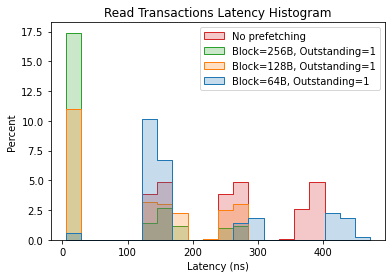

In [158]:
# NW
files = {
    "nw_256_16_1_1667402325.csv":"No prefetching", 
    "nw_256_16_1_1667403242.csv":"Block=256B, Outstanding=1",
    "nw_256_16_1_1667403519.csv":"Block=128B, Outstanding=1",
    "nw_256_16_1_1667403634.csv":"Block=64B, Outstanding=1",
}

plot_hist_latencies(files, 'Read Transactions Latency Histogram')

In [159]:
#Summary

summaryDf = pd.read_csv(github_url+test_results_dir+"sim_summary.csv")

def plot_summary_compare(useCase,yColumn,yLabel,splitBy,xColumn,xLabel,splitByLegend,valueScale=1):
  df = summaryDf[summaryDf['use case'] == useCase]
  # Get value when we dont use the prefetcher
  valueNoPrefetch = df[df['USE_PREFETCHER'] == 0][yColumn][0]

  joined=pd.DataFrame()
  for i in df[splitBy].unique():
    currnetDf = df[(df[splitBy] == i) & (df['USE_PREFETCHER'] == 1)]
    selectedCols = currnetDf[[yColumn,xColumn]]
    selectedCols = selectedCols.set_index(xColumn)
    selectedCols = selectedCols.rename(columns={yColumn:splitByLegend(i)})
    joined = joined.join(selectedCols, rsuffix=i,how="outer")
  joined['Without prefetch']= valueNoPrefetch
  joined = joined * valueScale
  joined.plot(xlabel = xLabel, ylabel = yLabel)


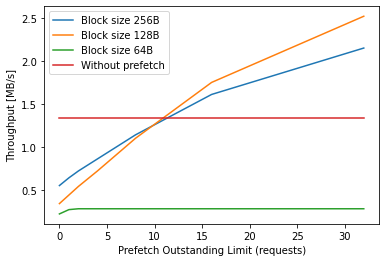

In [160]:
plot_summary_compare(useCase = "nw_256_16_1",
                     yColumn='ddr bus throughput [B/ns]',
                     yLabel='Throughput [MB/s]',
                     splitBy='LOG_BLOCK_SIZE',
                     xColumn='CRS_OUTSTAND_LIM',
                     xLabel = 'Prefetch Outstanding Limit (requests)',
                     splitByLegend= lambda n : f'Block size {pow(2,n)}B',
                     valueScale = 1000)